In [429]:
import numpy as np 
import matplotlib.pyplot as plt 

def simulated_response(theta, theta_tune, N,  C=1, kappa=3):
    Rmax=60
    t=1 #s
    f = np.exp(kappa*(np.cos(theta-theta_tune)-1))
    response = np.random.poisson(lam=f*Rmax*t*C, size=N)
    return response

def false_alarm_response(N):
    Rmin=10
    t=1 #s
    response = np.random.poisson(lam=Rmin*t, size=N)
    return response
    
def log_likelihood(response, theta, theta_tune, kappa=3):
    return np.dot(response, kappa*(np.cos(np.ones(np.shape(theta_tune))*theta-theta_tune)))




# Building the Likelihood

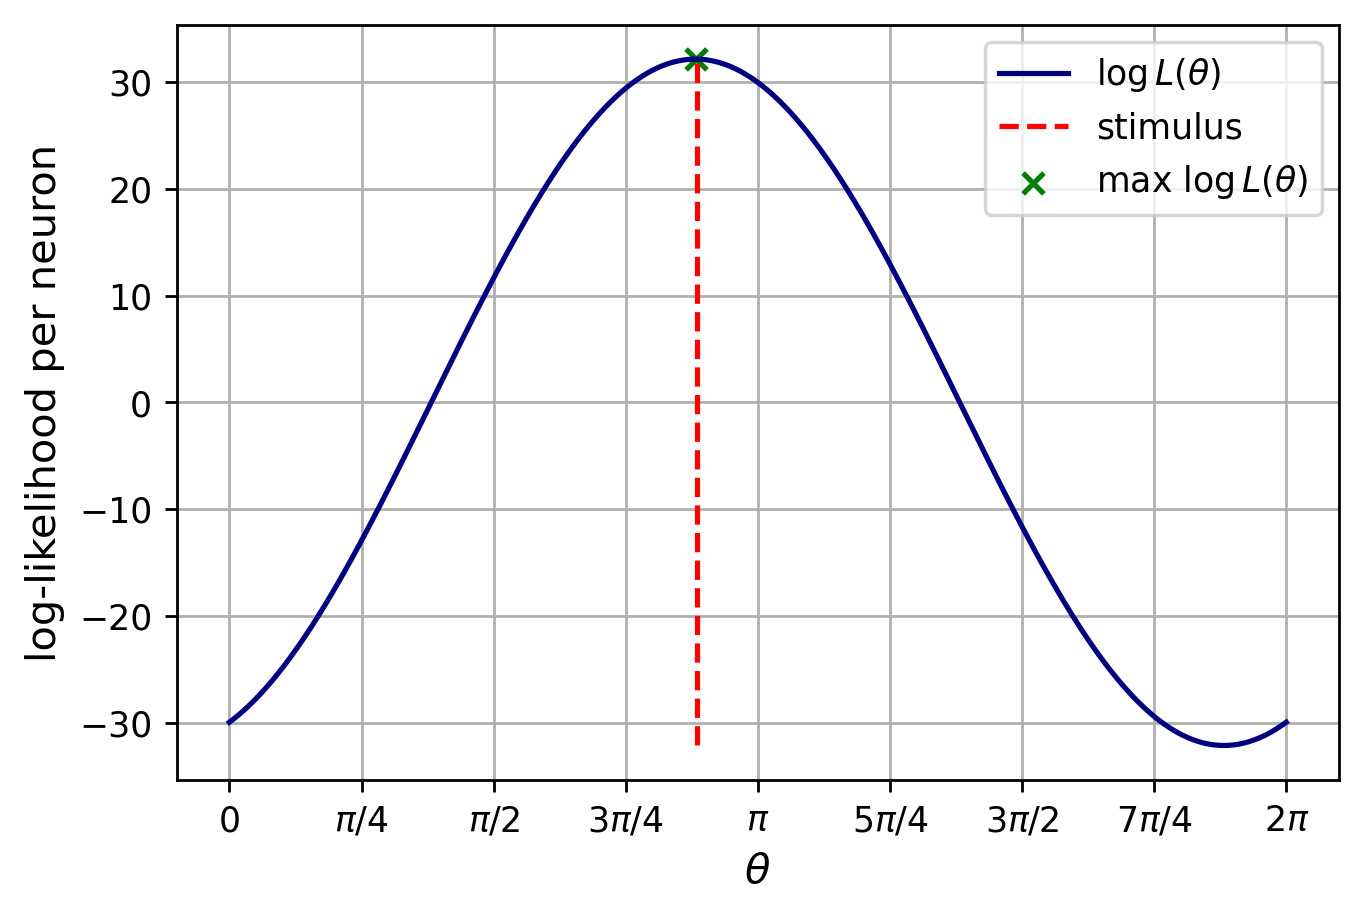

In [443]:
N = 720

theta_range = np.linspace(0, 2*np.pi, 10000)
theta_tune = np.random.choice(theta_range, size=N)

random_theta = np.random.choice(theta_range)
response = simulated_response(theta=random_theta, theta_tune=theta_tune , N=N, C=1)


full_log_likelihood=np.array([log_likelihood(response, theta=theta, theta_tune=theta_tune) for theta in theta_range])

plt.figure(dpi=250)
plt.plot(theta_range, full_log_likelihood/N, label="$\log L(\\theta)$", c="navy")
plt.vlines(x=random_theta, ymin=np.min(full_log_likelihood/N), 
                ymax=np.max(full_log_likelihood/N), color="red", 
                linestyles='dashed', label="stimulus")
plt.scatter(theta_range[np.argmax(full_log_likelihood)], 
                np.max(full_log_likelihood)/N, c="g", marker="x",
                label="max $\log L(\\theta)$")
plt.xlabel("$\\theta$", fontsize=12)
plt.ylabel("log-likelihood per neuron", fontsize=12)
plt.xticks([n*np.pi/4 for n in range(9)], labels=["0", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$", "$5\pi/4$","$3\pi/2$", "$7\pi/4$","$2\pi$"], )
plt.legend()
plt.grid()

# Behavior for different N

In [312]:
N_range=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
n_trials=1000
theta_range = np.linspace(0, 2*np.pi, 1000)

diff=np.zeros(shape=(n_trials, len(N_range)))
j=0
for N in N_range:
    i=0
    for trial in range(n_trials):
        theta_tune = np.random.choice(theta_range, size=N)
        random_theta_index = np.random.randint(0, len(theta_range))
        random_theta = theta_range[random_theta_index]
        response = simulated_response(theta=random_theta, theta_tune=theta_tune , N=N)
        full_log_likelihood=[]
        for theta in theta_range:
            full_log_likelihood.append(log_likelihood(response, theta, theta_tune))
        diff[i][j] = np.abs(theta_range[np.argmax(full_log_likelihood)] - random_theta)
        i+=1
    j+=1
mean_diff = np.mean(diff, axis=0)
std_diff = np.std(diff, axis=0)


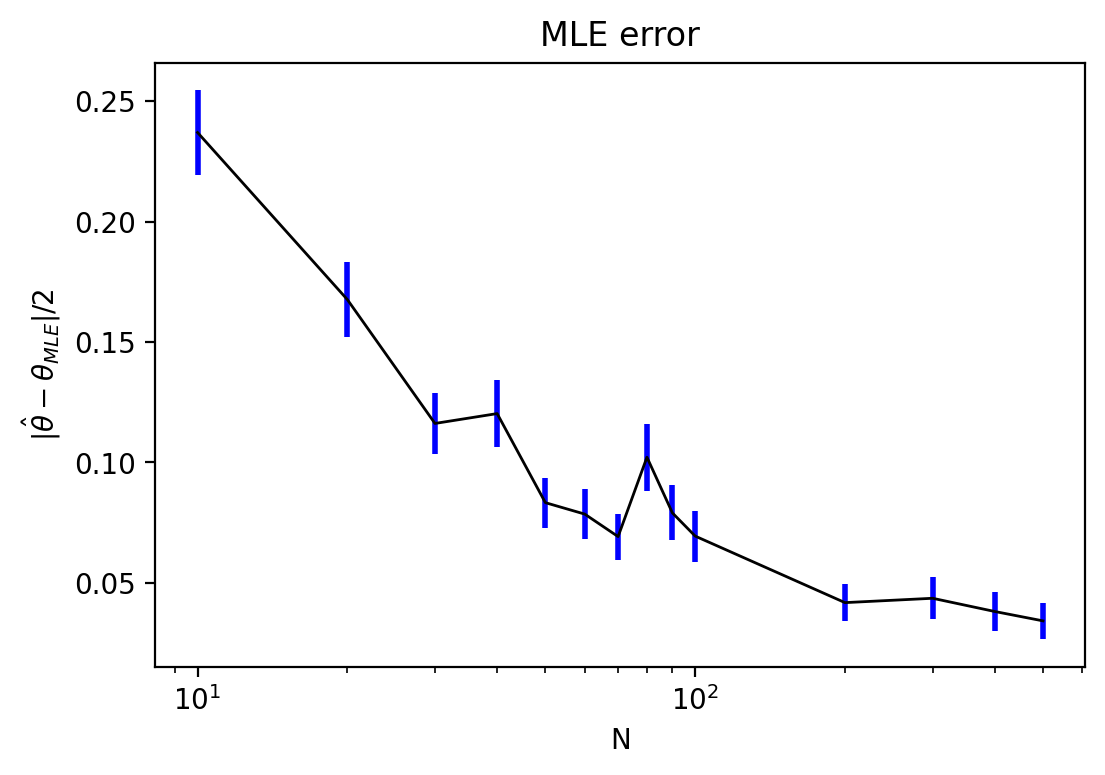

In [313]:
plt.figure(dpi=200)
plt.errorbar(N_range, mean_diff/2, yerr=std_diff/(2*np.sqrt(n_trials)), color="black", ecolor="blue", linewidth=1, elinewidth=2)
#check y error normaliz factor
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("N")
plt.ylabel("$|\hat{\\theta}-\\theta_{MLE}|/2$")
plt.title("MLE error")
plt.show()

# Discriminating Two Directions (for different choices of N)
criterion: difference of the log likelihood (Coherence set to 1)

In [ ]:
import matplotlib.pylab as pl
colrs = pl.cm.viridis(np.linspace(0, 0.8, 3))
colrs

In [468]:
from sklearn.metrics import roc_curve, auc

def angle_diff(ang1, ang2):
    return np.abs((ang1-ang2) % (2*np.pi))

def roc(N,theta, delta_theta, n_trials, kappa=3, C=1):
    theta_range = np.linspace(0, 2*np.pi, 10000)
    theta_1 = theta_range[np.argmin(angle_diff(theta_range, theta))] #the correct angle
    theta_2 = theta_range[np.argmin(angle_diff(theta_range, theta+delta_theta))]  #angle to compare
    stimuli_angles=[theta_1, theta_2]
    theta_tune = np.random.choice(theta_range, size=N)
    score=[]
    y_true=[]
    for trial in range(n_trials):
        y=np.random.choice([0, 1])
        y_true.append(y)
        response = simulated_response(theta=stimuli_angles[y], theta_tune=theta_tune , N=N, C=1)
        score.append(log_likelihood(response, stimuli_angles[1], theta_tune)-log_likelihood(response, stimuli_angles[0], theta_tune))
    #score=np.exp(np.array(score))
    fpr, tpr, _= roc_curve(y_true, score)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


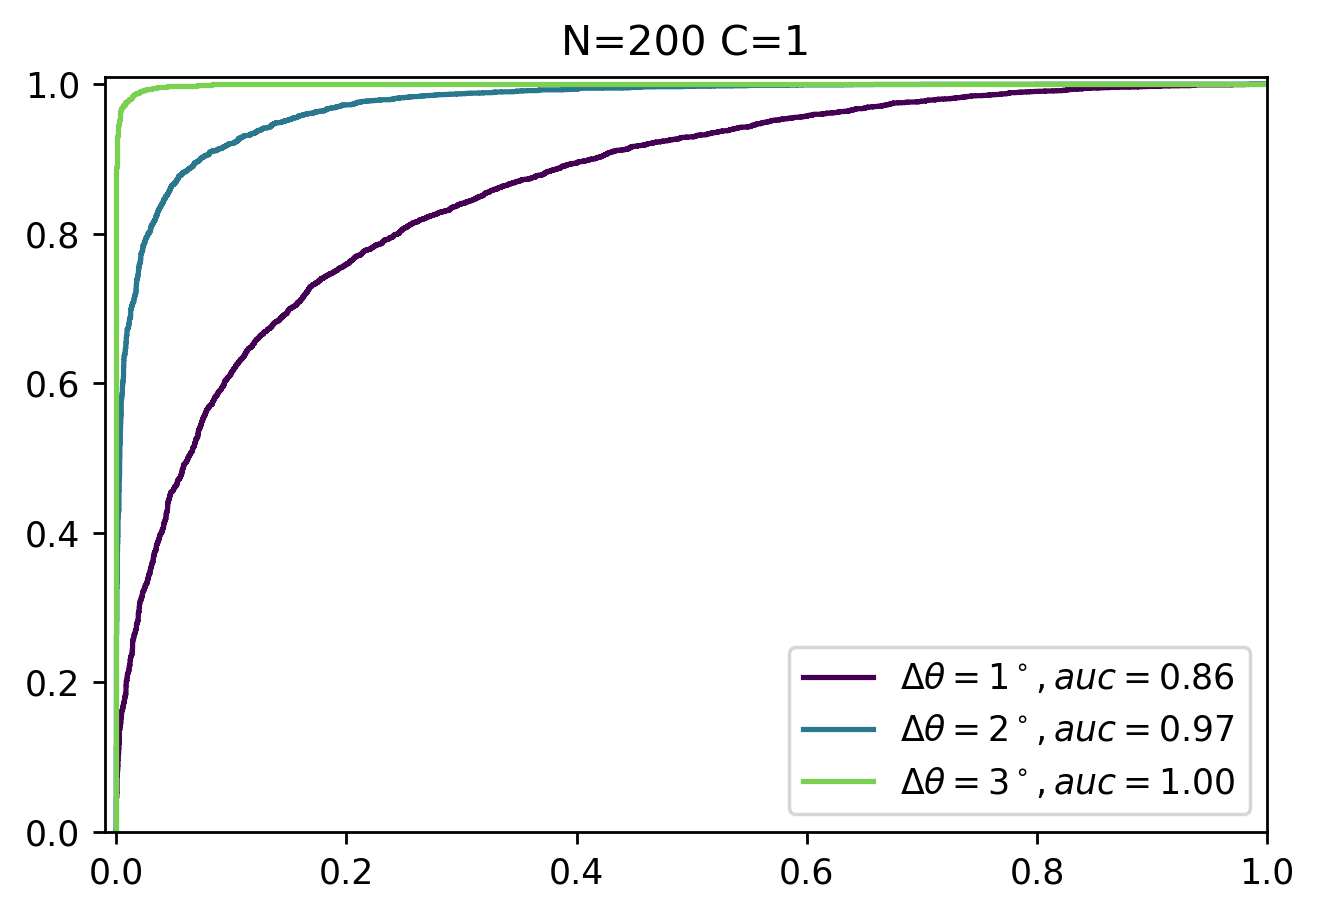

In [469]:
delta_angles= [1, 2, 3]
N= 200
i=0
plt.figure(dpi=250)
for delta in delta_angles:
    fpr, tpr, auc_score = roc(N, theta=0, delta_theta=delta/180*np.pi, n_trials=10000)
    plt.plot(fpr, tpr, label="$\Delta \\theta = " +str(delta)+ "^\circ, auc= %.2f$" %  auc_score, color=colrs[i])
    plt.xlim(-0.01,1)
    plt.ylim(0,1.01)
    i+=1

plt.title("N="+str(N)+" C=1")
plt.legend()
plt.show()

# Detection

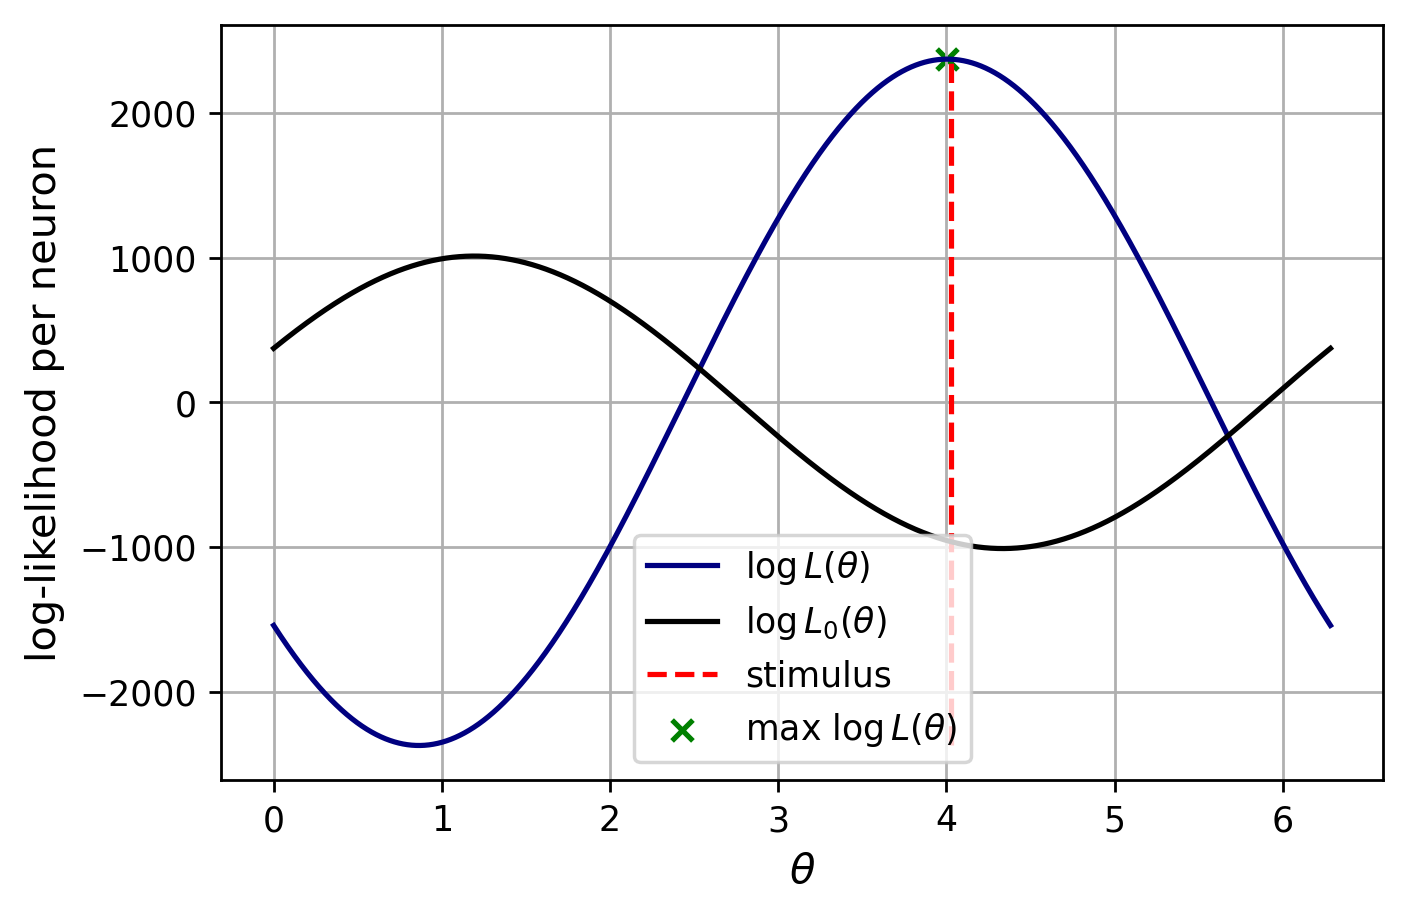

In [428]:
N=700
theta_range = np.linspace(0, 2*np.pi, 10000)
theta_tune = np.random.choice(theta_range, size=N)
random_theta = np.random.choice(theta_range)
response = simulated_response(theta=random_theta, theta_tune=theta_tune , N=N, C=0.1)


response_0 = false_alarm_response(N)
full_log_likelihood=[]
full_log_likelihood_0=[]

for theta in theta_range:
    full_log_likelihood.append(log_likelihood(response, theta, theta_tune))
    full_log_likelihood_0.append(log_likelihood(response_0, theta, theta_tune))

full_log_likelihood=np.array(full_log_likelihood)

plt.figure(dpi=250)
plt.plot(theta_range, full_log_likelihood, label="$\log L(\\theta)$", c="navy")
plt.plot(theta_range, full_log_likelihood_0, label="$\log L_0(\\theta)$", c="k")

plt.vlines(x=random_theta, ymin=np.min(full_log_likelihood), 
                ymax=np.max(full_log_likelihood), color="red", 
                linestyles='dashed', label="stimulus")
plt.scatter(theta_range[np.argmax(full_log_likelihood)], 
                np.max(full_log_likelihood), c="g", marker="x",
                label="max $\log L(\\theta)$")
plt.xlabel("$\\theta$", fontsize=12)
plt.ylabel("log-likelihood per neuron", fontsize=12)
plt.legend()
plt.grid()
